In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import copy
import plotly.graph_objects as go
import plotly.express as px
import random

from bertopic import BERTopic
from typing import List, Union
from sklearn.preprocessing import normalize

/home/cattiaux/anaconda3/envs/wassati/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cattiaux/anaconda3/envs/wassati/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cattiaux/anaconda3/envs/wassati/lib/python3.9/site-packages/

In [2]:
df = pd.read_csv("/media/cattiaux/DATA/Wassati/team_data/schneider/df_all_labelled.csv", dtype={'year': str})

/tmp/ipykernel_16242/1730781217.py:1: DtypeWarning: Columns (10,11,15,19,20,21,23,34,35,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/media/cattiaux/DATA/Wassati/team_data/schneider/df_all_labelled.csv", dtype={'year': str})


In [3]:
### chargement du model bertopic

def load_bertopic_model(filename):
    """
    Load a BERTopic model and associated data from a file.
    
    :param filename: The name of the file to load the data from.
    :return: A tuple containing the loaded BERTopic model, topics, probs, and docs variables.
    """
    # Load the BERTopic model
    topic_model = BERTopic.load(filename)
    
    # Load the topics, probs, and docs variables
    with open(filename + '_data.pkl', 'rb') as f:
        topics, probs, embeddings, docs = pickle.load(f)
    
    return topic_model, topics, probs, embeddings, docs

topic_model, topics, probs, embeddings, docs = load_bertopic_model('../models/raw_keybert_bertopic_model')

def create_merged_model(docs, bertopic_model, topics_to_merge_dict, label_names_dict):
    """
    Create a new BERTopic model by merging topics from an existing model.

    This function takes as input a list of documents `docs`, an existing BERTopic model `bertopic_model`, a dictionary `topics_to_merge_dict` specifying which topics to merge, and a dictionary `label_names_dict` specifying the labels for the merged topics.

    The function creates a deep copy of the input BERTopic model and merges the specified topics using the `merge_topics` method. Then, it sets the topic labels for the merged model using the `set_topic_labels` method and the provided `label_names_dict`.

    The resulting merged BERTopic model is then returned.

    Parameters:
        docs (list): A list of documents used to fit the BERTopic model.
        bertopic_model (BERTopic): The input BERTopic model to be merged.
        topics_to_merge_dict (dict): A dictionary specifying which topics to merge. The keys are the topic numbers to be merged, and the values are the topic numbers into which they should be merged.
        label_names_dict (dict): A dictionary specifying the labels for the merged topics. The keys are the topic numbers, and the values are the corresponding labels.

    Returns:
        BERTopic: The resulting merged BERTopic model.
    """
    topic_model_merged = copy.deepcopy(bertopic_model)
    topic_model_merged.merge_topics(docs, topics_to_merge_dict)

    # Create a dictionary to match the aggregated name to their corresponding topic number
    mergedtopic_labels_dict = {i-1: item for i, item in enumerate(label_names_dict)}
    # Set topic labels for the aggregated model
    topic_model_merged.set_topic_labels(mergedtopic_labels_dict)

    return topic_model_merged### Création du modèle bertopic aggrégé pour topics finaux

# List of topics numbers. Each value of this list is a list that contains the topic number of the topics to join together
topics_to_merge = [ [42,3,0,13], #Delivery Deadlines : challenges and strategies involved in managing delivery deadlines in logistics operations. (vert)
                    [20,50,27], #Quotation and Pricing Strategies (vert bas)
                    [35,32], #Touch Panels and Screens (rouge, haut)
                    [40,36], #Frequency Converters : frequency converters used in industrial applications and the technical support provided by manufacturers and suppliers (rouge, suite)
                    [37,21,6,12,9,4,1,14,16,31,19], #“Automation Components” : hardware and software components used in industrial automation systems. (rouge centre)
                    [33,46,8], #Product Evaluation : evaluate the quality, affordability and reliability of products and services (rouge, fin)
                    [44,51,23,41,49,57,22], #Customer Support : Reliability and Quality in Customer Service and Support (bleu ciel)
                    [58,59], #Quick Customer Service (marron)
                    [38,10,26,52,39,43], #Problem Solving and Communication (focus on the importance of being efficient and precise when solving problems) (jaune)
                    [45,47,55,53,54], #Assistance and Guidance (noir)
                    [29,30,11,24], #Power Supply Issues (2e vert, haut)
                    [7,5,2,25,15,34,18,28,17], #Technical Support (2e vert, bas)
                    [48,56] #None : positive feedback (2e rouge)
]

# Set the topic names for the new aggregated topic
# It must match the order from the topics_to_merge list
label_names = [
    "Outliers",
    "Automation Components",
    "Technical Support",
    "Delivery Deadlines",
    "Problem Solving & Comm",
    "Power Supply Issues",
    "Customer Support", #Reliability and Quality in Customer Service and Support
    "Product Evaluation",
    "Pricing", #Quotation and Pricing Strategies
    "Assistance", #Assistance and Guidance
    "Touch Screens", #Touch Panels and Screens
    "Frequency Converters",
    "Positive feedback",
    "Quick Customer Service"
    ]

# Create a new merged bertopic model 
topic_model_merged = create_merged_model(docs, topic_model, topics_to_merge, label_names)
# topic_model_merged.get_topic_info()

/home/cattiaux/anaconda3/envs/wassati/lib/python3.9/site-packages/bertopic/vectorizers/_ctfidf.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)


In [4]:
def add_percentage(df, topic_col='Topic', freq_col='Frequency', include_outliers=False):
    """
    This function adds two percentage columns to a dataframe. The first percentage is calculated as the frequency of each topic within each class. The second percentage is calculated as the frequency of each class within each topic.
    
    Parameters:
    df (DataFrame): The input dataframe.
    topic_col (str, optional): The name of the topic column in the dataframe. Defaults to 'Topic'.
    freq_col (str, optional): The name of the frequency column in the dataframe. Defaults to 'Frequency'.
    include_outliers (bool, optional): Whether to include outliers (topic number -1) in the percentage computation. Defaults to True.

    Returns:
    DataFrame: A dataframe with added 'Topic_Percentage' and 'Class_Percentage' columns.
    """ 
    # If not including outliers, remove them from the dataframe
    if not include_outliers:
        df = df[df[topic_col] != -1]

    # Check if columns exist in dataframe
    for col in [col for col in [topic_col, freq_col] if col is not None]:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in dataframe. The function will proceed with default column names.")

    # Calculate the total frequency per topic
    df_total_topic = df.groupby(topic_col)[freq_col].sum().reset_index()
    df_total_topic.columns = [topic_col, 'Total_Topic']

    # Calculate the total frequency per class
    df_total_class = df.groupby("Class")[freq_col].sum().reset_index()
    df_total_class.columns = ["Class", 'Total_Class']

    # Merge these two dataframes with original dataframe
    df_merged = pd.merge(df, df_total_topic, on=topic_col)
    df_merged = pd.merge(df_merged, df_total_class, on="Class")

    # Calculate the percentages and round to 2 decimal places
    df_merged['Topic_Percentage'] = (df_merged[freq_col] / df_merged['Total_Topic'] * 100).round(2)
    df_merged['Class_Percentage'] = (df_merged[freq_col] / df_merged['Total_Class'] * 100).round(2)
    
    # Replace NaN values with 0
    df_merged['Topic_Percentage'].fillna(0, inplace=True)
    df_merged['Class_Percentage'].fillna(0, inplace=True)

    # Drop the 'Total' columns
    df_merged.drop(columns=['Total_Topic', 'Total_Class'], inplace=True)

    return df_merged

def add_customLabelCol(df, bertopic_model):
    """
    This function adds a new column 'Name' to the input DataFrame 'df' based on the custom labels 
    from the BERTopic model 'bertopic_model'. The new column 'Name' is mapped from the 'Topic' 
    column of the DataFrame using the custom labels.

    Parameters:
    df (pandas.DataFrame): The input DataFrame to which the new column will be added.
    bertopic_model (BERTopic): The BERTopic model which contains the custom labels.

    Returns:
    new_df (pandas.DataFrame): The DataFrame with the added 'Name' column.
    """
    new_df=df
    custom_labels = bertopic_model.custom_labels_
    custom_labels_dict = {i-1: label for i, label in enumerate(custom_labels)}
    # Add a new column 'Custom_Label' to the DataFrame
    new_df['Name'] = new_df['Topic'].map(custom_labels_dict)
    return new_df

def create_topics_per_class_df(df, bertopic_model, classes_column, filter_value=None,  sortedBy=None, ascending=True):
    """
    Computes the distribution of topics per class in the given DataFrame. Optionally filters the data by a given subclass and sorts the resulting DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame.
    bertopic_model (BERTopic): The BERTopic model used to compute the topics.
    classes_column (str): The name of the column in df that contains the class values.
    filter_value (str, optional): The value of the subclass to filter the data by. Required if filter is True.
    sortedBy (str, optional): Column name to sort by. Must be either None (default), 'Frequency', 'Class', 'Topic_Percentage' or 'Class_Percentage'.
    ascending (bool, optional): Whether to sort in ascending order. Default is True. Can only be used if sortedBy is not None.

    Returns:
    pandas.DataFrame: A DataFrame containing the topic number, the list of words that describe the topic, and the frequency and percentage of documents from this topic that belong to each class.
    """
    # Check that the value of sortedBy is valid
    if sortedBy not in [None, "Frequency", "Class", "Topic_Percentage", "Class_Percentage"]:
        raise ValueError("sortedBy must be either None (default value), 'Frequency',  'Class', 'Topic_Percentage' or 'Class_Percentage'")
    # Check that ascending is only used if sortedBy is not None
    if sortedBy is None and ascending != True:
        raise ValueError("ascending can only be used if sortedBy parameter is used")
    # Check that the value of ascending is valid
    if ascending not in [True, False]:
        raise ValueError("ascending must be either True or False")
    
    # Compute topics_per_class dataframe using bertopic method
    topics_per_class = bertopic_model.topics_per_class(df["processed_data"].astype(str).tolist(), classes=df[classes_column].to_list())
    # Add percentage columns to dataframe
    topics_per_class = add_percentage(topics_per_class, topic_col='Topic', freq_col='Frequency')

    if filter_value : 
        # Filter your data based on the values from the chosen subclass
        topics_per_class = topics_per_class[topics_per_class['Class'] == filter_value]

        # Add rows for missing topics with a frequency of 0
        topic_words = {row['Topic']: row['Name'] for _, row in bertopic_model.get_topic_info().iterrows()}
        missing_topics = {topic for topic in bertopic_model.get_topics().keys() if topic != -1} - set(topics_per_class['Topic'].unique())
        for topic in missing_topics:
            for class_ in topics_per_class['Class'].unique():
                new_row = pd.DataFrame({
                    'Topic': [topic],
                    'Words': [topic_words[topic]],
                    'Frequency': [0],
                    'Topic_Percentage': [0],
                    'Class_Percentage': [0],
                    'Class': [class_]
                })
                topics_per_class = pd.concat([topics_per_class, new_row], ignore_index=True)

    # Check if there are existing custom_labels names in the bertopic model and add them in a column if there are some
    if bertopic_model.custom_labels_ is not None :
        topics_per_class = add_customLabelCol(topics_per_class, bertopic_model)
    # Sort the dataframe to prepare the visualization
    if sortedBy:
        topics_per_class = topics_per_class.sort_values(by=sortedBy, ascending=ascending)
    
    return topics_per_class

def visualize_topics_per_class_options(topic_model, topics_per_class, orient="h", percentage_by=None, viz_from_source=False, stacked=False, **kwargs):
    """
    Visualizes the distribution of topics per class with additional options for orientation and percentage usage.

    Parameters:
    topic_model : The trained BERTopic model.
    topics_per_class : A DataFrame containing the topics per class.
    orient (str, optional): The orientation of the plot. Defaults to "h".
    use_percentage (bool, optional): Whether to use percentage for the representation of the data. Defaults to False.
    **kwargs: Arbitrary keyword arguments for the visualize_topics_per_class_orient function.

    Returns:
    go.Figure: A Plotly figure object containing the visualization.
    """
    # Modify the visualize_topics_per_class method from bertopic to be able to print a barchart vertically
    def visualize_topics_per_class_orient(topic_model,
                                topics_per_class: pd.DataFrame,
                                top_n_topics: Union[int,None] = None,
                                topics: List[int] = None,
                                normalize_frequency: bool = False,
                                percentage_by: Union[str,None] = None,
                                custom_labels: Union[bool, str] = False,
                                title: str = "<b>Topics per Class</b>",
                                width: int = 1250,
                                height: int = 900,
                                orient: str = "h") -> go.Figure:
        """
        Visualizes the distribution of topics per class.

        Parameters:
        topic_model : The trained BERTopic model.
        topics_per_class (pd.DataFrame): A DataFrame containing the topics per class.
        top_n_topics (int, optional): The number of top topics to visualize. Defaults to 10.
        topics (List[int], optional): A list of specific topics to visualize. Defaults to None.
        normalize_frequency (bool, optional): Whether to normalize the frequency. Defaults to False.
        percentage_by (string, optional): Which percentage calcul to use for the representation of the data. Defaults to None.
        custom_labels (Union[bool, str], optional): Whether to use custom labels for the topics. Defaults to False.
        title (str, optional): The title of the plot. Defaults to "<b>Topics per Class</b>".
        width (int, optional): The width of the plot. Defaults to 1250.
        height (int, optional): The height of the plot. Defaults to 900.
        orient (str, optional): The orientation of the plot. Defaults to "h".

        Returns:
        go.Figure: A Plotly figure object containing the visualization.
        """
        colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#D55E00", "#0072B2", "#CC79A7"]

        if percentage_by not in ["Topic","Class",None] :
            raise ValueError("'percentage_by' possible values are ['Topic','Class', None]")
    
        # Select topics based on top_n and topics args
        freq_df = topic_model.get_topic_freq()
        freq_df = freq_df.loc[freq_df.Topic != -1, :]
        if topics is not None:
            selected_topics = list(topics)
        elif top_n_topics is not None:
            selected_topics = sorted(freq_df.Topic.to_list()[:top_n_topics])
        else:
            selected_topics = sorted(freq_df.Topic.to_list())

        # Prepare data
        if isinstance(custom_labels, str):
            topic_names = [[[str(topic), None]] + topic_model.topic_aspects_[custom_labels][topic] for topic in topics]
            topic_names = ["_".join([label[0] for label in labels[:4]]) for labels in topic_names]
            topic_names = [label if len(label) < 30 else label[:27] + "..." for label in topic_names]
            topic_names = {key: topic_names[index] for index, key in enumerate(topic_model.topic_labels_.keys())}
        elif topic_model.custom_labels_ is not None and custom_labels:
            topic_names = {key: topic_model.custom_labels_[key + topic_model._outliers] for key, _ in topic_model.topic_labels_.items()}
        else:
            topic_names = {key: value[:40] + "..." if len(value) > 40 else value
                        for key, value in topic_model.topic_labels_.items()}
        topics_per_class["Name"] = topics_per_class.Topic.map(topic_names)
        data = topics_per_class.loc[topics_per_class.Topic.isin(selected_topics), :]

        # Add traces
        fig = go.Figure()
        for index, topic in enumerate(selected_topics):
            if index == 0:
                visible = True
            else:
                visible = "legendonly"
            trace_data = data.loc[data.Topic == topic, :]
            topic_name = trace_data.Name.values[0]
            words = trace_data.Words.values

        # Check if 'percentage_by' is defined and if the corresponding percentage column exists, and use it for x values if it does
            if percentage_by is not None :
                col_name = f'{percentage_by}_Percentage'
                if col_name in trace_data.columns:
                    x = trace_data[col_name]
                else:
                    raise ValueError(f"{col_name} column does not exist")
            elif normalize_frequency:
                x = normalize(trace_data.Frequency.values.reshape(1, -1))[0]
            else:
                x = trace_data.Frequency

            ### Old part from the source github of bertopic ###
            # fig.add_trace(go.Bar(y=trace_data.Class,
            #                      x=x,
            #                      visible=visible,
            #                      marker_color=colors[index % 7],
            #                      hoverinfo="text",
            #                      name=topic_name,
            #                      orientation="h",
            #                      hovertext=[f'<b>Topic {topic}</b><br>Words: {word}' for word in words]))
            
            fig.add_trace(go.Bar(y=trace_data.Class if orient == "h" else x,
                                x=x if orient == "h" else trace_data.Class,
                                visible=visible,
                                marker_color=colors[index % 7],
                                hoverinfo="text",
                                name=topic_name,
                                orientation=orient,
                                hovertext=[f'<b>Topic {topic_names[topic]}</b><br>Words: {word}' for word in words] if percentage_by==None else [f'<b>Topic {topic_names[topic]}</b><br>Words: {word}<br>Percentage: {p}%' for word, p in zip(words, x)]
                                ))

        # Styling of the visualization
        fig.update_xaxes(showgrid=True)
        fig.update_yaxes(showgrid=True)
        fig.update_layout(
            xaxis_title="Normalized Frequency" if normalize_frequency else "Frequency",
            yaxis_title="Class",
            barmode='stack' if stacked else "group",
            title={
                'text': f"{title}",
                'y': .95,
                'x': 0.40,
                'xanchor': 'center',
                'yanchor': 'top',
                'font': dict(
                    size=22,
                    color="Black")
            },
            template="simple_white",
            width=width,
            height=height,
            hoverlabel=dict(
                bgcolor="white",
                font_size=16,
                font_family="Rockwell"
            ),
            legend=dict(
                title="<b>Global Topic Representation",
            )
        )
        return fig

    if viz_from_source==True and (orient!="h" or percentage_by!=None):
        raise ValueError("the option 'orient' and 'percentage_by' are not available in the visualization from bertopic source code")
    if orient=="h" and percentage_by==None and viz_from_source==True:
        # using the source method to do it, without having the possibility to choose the orient (at the date of 09/2023)
        # we keep the use of the source method even if we could use only the new visualize_topics_per_class_orient. Because it permits to know and enjoy the modifications done in visualize_topics_per_class in the future by the owner of this source code
        fig = topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=None, **kwargs)
    else:  
        # using the modified source method to do it, adding the option to print the chart vertically
        fig = visualize_topics_per_class_orient(topic_model, topics_per_class, orient=orient, percentage_by=percentage_by, **kwargs)

    return fig

def create_chart_per_class(
                            df, 
                            bertopic_model, 
                            classes_column, 
                            filter_value=None, 
                            sortedBy=None, 
                            ascending=True, 
                            orient="h",
                            viz_from_source=False,
                            stacked=False,
                            percentage_by=None,
                            **kwargs):
    """
    Create a chart representing the topics per class.

    This function takes as input a dataframe `df`, a BERTopic model `bertopic_model`, a column name `classes_column` representing the classes, an optional parameter `filter_value` representing the value of the class to filter on, an optional parameter `sortedBy` which can be used to sort the topics by either "Frequency" or "Name", an optional boolean parameter `ascending` which determines the sorting order (ascending or descending), an orientation `orient` which can be either horizontal ("h") or vertical ("v"), and additional keyword arguments `**kwargs`.

    The function first calls the `create_topics_per_class_df` function to create a dataframe representing the topics per class. Then, it calls the `visualize_topics_per_class_options` function to create a chart from this dataframe. The resulting chart is then returned.

    Parameters:
        df (pandas.DataFrame): The input dataframe containing the data to be visualized.
        bertopic_model (BERTopic): The BERTopic model used to calculate the topics per class.
        classes_column (str): The name of the column in `df` representing the classes.
        filter_value: An optional parameter representing the value of the subclass to filter on. Only used if `filter` is True. Defaults to None.
        sortedBy (str): An optional parameter used to sort the topics by either "Frequency" or "Name". Defaults to None.
        ascending (bool): An optional boolean parameter used to determine the sorting order. If True, sorts in ascending order. If False, sorts in descending order. Defaults to True.
        orient (str): The orientation of the visualization. Can be either "h" for horizontal or "v" for vertical. Defaults to "h".
        **kwargs: Additional keyword arguments passed to the visualization method.

    Returns:
        plotly.graph_objs.Figure: The resulting chart representing the topics per class.
    """
    topics_per_class = create_topics_per_class_df(df, bertopic_model, classes_column, filter_value=filter_value, sortedBy=sortedBy, ascending=ascending)
    fig = visualize_topics_per_class_options(bertopic_model, topics_per_class, orient=orient, viz_from_source=viz_from_source, stacked=stacked, percentage_by=percentage_by, **kwargs)

    return fig 

def save_graph_html(fig, path, name):
    """
    Saves a Plotly figure as an HTML file at the specified path.

    Parameters:
    fig (go.Figure): The Plotly figure to save.
    path (str): The directory where the HTML file will be saved.
    name (str): The name of the HTML file (without the .html extension).

    Returns:
    None
    """
    # Create the directory if it doesn't exist
    if not os.path.exists(path):
        os.makedirs(path)
        
    return fig.write_html(path+"/"+name+".html")

In [5]:
fig = create_chart_per_class(df, topic_model_merged, "sentiment_label", 
                             sortedBy="Frequency", 
                             orient="v", 
                             custom_labels=True, 
                             percentage_by="Class",
                             title="Topics per Sentiment", 
                             width=500, height=750)

In [6]:
fig = create_chart_per_class(df, topic_model_merged, "single_emotion_label", 
                             custom_labels=True, 
                             percentage_by=None,
                            #  stacked=True,
                             title="Topics per Emotion", 
                             width=1150, height=750)

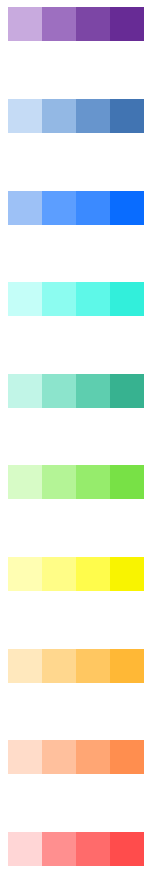

In [86]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the colors
colors = ["#FFFB8D", "#F5F05F", "#FFC974", "#FFA674", "#5ECEAF", "#8CE4CC", "#5DFBEA"]

brand_colors = {
    "violet": {
        "light": "#C8AADE",
        "normal": "#9D6FC0",
        "dark": "#7C46A5",
        "dark2": "#672B95"
    },
    "bleu marine": {
        "light": "#C5DBF5",
        "normal": "#93B8E4",
        "dark": "#6795CD",
        "dark2": "#4174B2"
    },
    "bleu roi": {
        "light": "#9DC1F6",
        "normal": "#5C9EFF",
        "dark": "#3B8AFF",
        "dark2": "#096CFF"
    },
    "cyan": {
        "light": "#C4FEF8",
        "normal": "#8CFCF0",
        "dark": "#5EF8E8",
        "dark2": "#32EFDB"
    },
    "bleu-vert": {
        "light": "#C1F5E7",
        "normal": "#8CE4CC",
        "dark": "#5ECEAF",
        "dark2": "#37B290"
    },
    "vert": {
        "light": "#D7FBC6",
        "normal": "#B4F496",
        "dark": "#96EC6C",
        "dark2": "#78E146"
    },
    "jaune": {
        "light": "#FFFEB2",
        "normal": "#FFFD87",
        "dark": "#FFFC4C",
        "dark2": "#F9F400"
    },
    "orange": {
        "light": "#FFE8BD",
        "normal": "#FFD78E",
        "dark": "#FFC761",
        "dark2": "#FFB836"
    },
    "orange-rouge": {
        "light": "#FFDCC9",
        "normal": "#FFC09D",
        "dark": "#FFA674",
        "dark2": "#FF8E4F"
    },
    "rouge": {
        "light": "#FFD6D6",
        "normal": "#FF8F8F",
        "dark": "#FF6B6B",
        "dark2": "#FF4C4C"
    },
}

def hex_to_rgb(color):
    return mcolors.hex2color(color)

def display_palette(palette):
    fig, ax = plt.subplots(len(palette), 1, figsize=(2, 12),
                           dpi=80, sharex=True, sharey=True)
    for i, color in enumerate(palette):
        ax[i].imshow([[hex_to_rgb(palette[color][shade]) for shade in palette[color]]])
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

# Create the colormap
colormap = LinearSegmentedColormap.from_list("my_colormap", colors, N=12)

# Generate a gradient image for demonstration
gradient = np.linspace(0, 1, 256)  # Gradient from 0 to 1
gradient = np.vstack((gradient, gradient))  # Stack to make a 2D image

# plt.imshow(gradient, aspect='auto', cmap=colormap)
# plt.show()

# Usage
display_palette(brand_colors)

In [8]:
### Graph barchart of one given emotion by a specified class (year, zone, etc.)

# Plot a bar chart or histogram of the distribution of a given emotion by a specified class
def plot_emotion(df, emotion, class_name, time_period=None, use_percentage=False, random_colors=True, set_colors=['#96ceb4', '#87bdd8', '#ffcc5c', '#ff6f69', '#f4a688', '#d96459'], set_color=None):
    """
    This function plots a bar chart of the distribution of a specified emotion by a specified class.

    Parameters:
    df (DataFrame): The input dataframe.
    emotion (str): The emotion to filter the dataframe by.
    class_name (str): The name of the class column in the dataframe.
    time_period (int, optional): The time period to filter the dataframe by. Defaults to None.
    use_percentage (bool, optional): Whether to calculate and plot percentages instead of counts. Defaults to False.
    random_colors (bool, optional): Whether to choose a color randomly from the set_colors list. If False, set_color must be provided. Defaults to True.
    set_colors (list of str, optional): The list of colors to choose from if random_colors is True. Defaults to ['#96ceb4', '#87bdd8', '#ffcc5c', '#ff6f69', '#f4a688', '#d96459'].
    set_color (str, optional): The color to use for the plot if random_colors is False. Defaults to None.

    Returns:
    Figure: A Plotly figure containing the bar chart.
    """
    # Check that set_color is provided if random_colors is False
    if random_colors==False and set_color is None:
        raise ValueError("set_color must be provided if random_colors is False")
    
    # Filter the data to only include rows with the specified emotion
    filtered_data = df[df['single_emotion_label'] == emotion]

    # Filter the data by the specified time period if provided
    if time_period != None:
        if class_name == 'year':
            raise ValueError("class_name cannot be 'year' when time_period is defined")
        filtered_data = filtered_data[filtered_data['year'] == time_period]

    if random_colors:
        # Randomly choose a color from the defined colors list
        colors_list = set_colors
        color = random.choice(colors_list)
    else:
        color = set_color

    # Calculate the percentage if use_percentage is True
    if use_percentage:
        total_per_zone = df.groupby(class_name).size()
        filtered_data = (filtered_data[class_name].value_counts() / total_per_zone * 100).reset_index()
        filtered_data.columns = [class_name, 'percentage']
        y_value = 'percentage'
    else:
        filtered_data = filtered_data[class_name].value_counts().reset_index()
        filtered_data.columns = [class_name, 'count']
        y_value = 'count'

    # Sort the data by ascending frequency if class_name is not 'year'
    if class_name != 'year':
        filtered_data.sort_values(by=y_value, ascending=True, inplace=True)

    fig = px.bar(filtered_data, x=class_name, y=y_value, color_discrete_sequence=[color], width=1100, height=600)

    # Set the axis labels
    fig.update_layout(xaxis_title=class_name, yaxis_title=y_value)
    # Set the title
    fig.update_layout(title=f'Distribution of {emotion} by {class_name}' + (f' in {time_period}' if time_period is not None else ''))
    # Center the title
    fig.update_layout(title_x=0.5)

    return fig

emotions = df['single_emotion_label'].unique()
class_name = "year"
time_period = None
# Loop over each emotion and save the corresponding graph
for emotion in emotions:
    fig = plot_emotion(df, emotion, class_name, time_period, use_percentage=True)
    # Export the chart as a PNG image
    # pio.write_image(fig, f'../data/graphs/Sentiment_Analysis/by_emotion/repartition/by_{class_name}/{emotion}_pct.png')

# plot_emotion(df, "admiration", "Zone", time_period=None, use_percentage=True)

In [5]:
#### Donut chart

def create_donut_chart(df, value):
    if value not in ["Frequency","Topic_Percentage","Class_Percentage"]:
        raise ValueError(f"{value} is not a discrete column from the df in parameter")
    # Create the donut chart
    fig = go.Figure(data=[go.Pie(labels=df['Name'], 
                                 values=df[value], 
                                 hole=.6,
                                #  marker=dict(colors=palette), 
                                # default:['#1f77b4',  '#ff7f0e',  '#2ca02c',  '#d62728',  '#9467bd',  '#8c564b',  '#e377c2',  '#7f7f7f',  '#bcbd22',  '#17becf']
                                 hovertemplate='%{label}: %{value}<extra></extra>'
                                )
                    ])
    
    fig.update_layout(
        legend_title_text='Topics',
        title={'text': "Topics' Repartition",
               'y':0.9,'x':0.5,
               'xanchor': 'center','yanchor': 'top'},
        title_font=dict(size=20,
                        color='rgb(107, 107, 107)'),
        autosize=False,
        width=800,
        height=500
    )
    return fig

res_df = create_topics_per_class_df(df, topic_model_merged, "year", filter_value="2018")
# Call the function with your dataframe and a specific year
fig = create_donut_chart(res_df, "Frequency")
fig
# Save the figure as an HTML file
# pio.write_html(fig, 'my_figure.html')

In [89]:
# Create Sunburst Chart
def filter_docs(df, filter_column, filter_value):
    filter_mask = df[filter_column] == filter_value
    return df[filter_mask], filter_mask

def compute_labels_and_parents(data_df, levels):
    grouped = data_df.groupby(levels).size()

    # Initialize lists
    labels = []
    parents = []

    # Compute labels and parents lists
    for i in range(len(levels)):
        for label, value in grouped.items(): # loop over the rows
            if label[i] not in labels:
                labels.append(label[i]) 
                parents.append("") if label[i] in data_df[levels[0]].values else parents.append(label[i-1])
    
    return labels, parents

def prepare_dataframe(data_df, levels):
    df_tmp=data_df.copy()
    frequency_col_name = "Count"
    df_tmp[frequency_col_name] = df_tmp.groupby(levels[-1])[levels[-1]].transform('count')
    sunburst_df = df_tmp[levels + [frequency_col_name]].drop_duplicates()
    sunburst_df[frequency_col_name] = sunburst_df[frequency_col_name].fillna(0)
    
    return sunburst_df

def compute_values(sunburst_df, labels, levels):
    values = []
    processed_labels = set()  # This set will store the labels that have been processed
    for label in labels:
        if label not in processed_labels:  # Only process the label if it has not been processed before
            for level in levels:
                if label in sunburst_df[level].values:
                    value = sunburst_df.loc[sunburst_df[level] == label, 'Count'].sum()
                    values.append(value)
                    processed_labels.add(label)  # Add the label to the set of processed labels
                    break  # No need to check other levels for this label
                    
    return values

def get_level(label, data_df, levels, return_highest_level=True): 
    # Find the levels that the label appears in
    found_levels = [level for level in levels if label in data_df[level].values]
    if not found_levels:
        # raise ValueError(f"Label {label} not found")
        return None
    # If return_highest is True, return the first level found (highest), else return the last level found (lowest)
    if return_highest_level:
        return found_levels[0]
    else:
        return found_levels[-1]

def compute_percentages(sunburst_df, data_df, labels, parents, values, levels):
    percentages = []
    percentages_class = []
    processed_labels = set()  # This set will store the labels that have been processed
    
    for level in levels:
        # Compute total count for each label in current level
        level_counts = sunburst_df.groupby(level)['Count'].sum()

        for i, label in enumerate(labels):
            if label not in processed_labels and label in sunburst_df[level].values:
                label_count = sunburst_df.loc[sunburst_df[level] == label, 'Count'].sum() 

                # Compute total count for the parent of current label with a condition if the label has a parent or not. 
                # Without parent, the total count is the count for all labels at this highest level
                total_count = values[labels.index(parents[i])] if parents[i]!='' else level_counts.sum()
                # Compute total count from original dataframe 
                total_count_class = data_df[get_level(label, data_df, levels)].value_counts().get(label)                

                # Compute percentage for current label
                percentage = (label_count / total_count) * 100
                percentages.append(percentage)
                percentage_class = (label_count / total_count_class) * 100
                percentages_class.append(percentage_class)
                processed_labels.add(label)  # Add the label to the set of processed labels

    return percentages, percentages_class

def transform_scale_list(lst,exponent=2, desire_sum=100):
    # Apply power transformation
    transformed_lst = [i**exponent for i in lst]

    # Scale the transformed data so that the total sum remains 100
    total = sum(transformed_lst)
    scaled_lst = [(i/total)*desire_sum for i in transformed_lst]
    return scaled_lst

def normalize_percentage_class(data_df, levels, labels, parents, percentages_class):
    # Init
    normalized_percentages_class = [0]*len(percentages_class)
    normalized_percentages_class_transform = [0]*len(percentages_class)

    ##### Highest level

    # Compute normalized_percentage_class for labels at the highest level (without parent)
    highest_level_labels = [label for label in labels if get_level(label, data_df, levels) == levels[0]]
    highest_level_indices = [labels.index(label) for label in highest_level_labels]
    total_highest_level_percentage = sum(percentages_class[i] for i in highest_level_indices)
    for i in highest_level_indices:
        normalized_percentages_class[i] = percentages_class[i] / total_highest_level_percentage * 100

    # scale the values for the highest level
    normalized_percentages_class_transform = transform_scale_list(normalized_percentages_class,4)

    ##### Other levels

    # Normalize percentages_class based on its parent
    for level in levels[1:]: #loop on the levels except the highest one
        level_labels = [label for label in labels if get_level(label, data_df, levels) == level]
        level_indices = [labels.index(label) for label in level_labels]

        # Loop to create the normalized_percentages_class list by level
        for indice in level_indices:
            sibling_indices = [j for j, parent in enumerate(parents) if parent == parents[indice]]
            total_sibling_percentage = sum(percentages_class[j] for j in sibling_indices)
            normalized_percentage_class = percentages_class[indice] / total_sibling_percentage * normalized_percentages_class[labels.index(parents[indice])]
            normalized_percentages_class[indice] = normalized_percentage_class

        # Loop to transform the normalized_percentages_class list by level : list normalized_percentages_class_transform
        indices_updated = [] # list to avoid several treatments on each label
        for indice in level_indices:
            if indice not in indices_updated:
                sibling_indices = [j for j, parent in enumerate(parents) if parent == parents[indice]]
                # Get & Transform norm_pct_class by family (brothers with the same parent)
                norm_pct_class_sibling = [normalized_percentages_class[i] for i in sibling_indices]
                norm_pct_class_sibling_transform = transform_scale_list(norm_pct_class_sibling,4, desire_sum=normalized_percentages_class_transform[labels.index(parents[indice])])
                # Store the transform norm_pct_class in the normalized_percentages_class_transform list
                for i, sibling_ind in enumerate(sibling_indices):
                    normalized_percentages_class_transform[sibling_ind] = norm_pct_class_sibling_transform[i]
                    indices_updated.append(sibling_ind)

    return normalized_percentages_class_transform

def add_unique_parent(labels, parents, values, unique_parent_name):
    unique_parent_value = sum(values[i] for i in range(len(parents)) if parents[i] == '')
    for i in range(len(labels)):
        if parents[i] == '':
            parents[i] = unique_parent_name
    labels.append(unique_parent_name)
    parents.append('')
    values.append(unique_parent_value)

    return labels, parents, values

def compute_lists(data_df, levels, class_column=None, class_value=None, unique_parent=False, unique_parent_name="Geo Levels"):
    if class_column and class_value==None:
        raise ValueError("When class_column is defined, class_value must be defined too and must be a value from the class_column column")
    
    work_df = data_df.copy()
    if class_column:
        work_df = filter_docs(data_df, class_column, class_value)[0]
    
    labels, parents = compute_labels_and_parents(work_df, levels)
    sunburst_df = prepare_dataframe(work_df, levels)
    values = compute_values(sunburst_df, labels, levels)
    # percentages, percentages_class, normalized_percentages_class = compute_percentages(sunburst_df, data_df, labels, parents, values, levels)
    percentages, percentages_class = compute_percentages(sunburst_df, data_df, labels, parents, values, levels)
    normalized_percentages_class_transform = normalize_percentage_class(data_df, levels, labels, parents, percentages_class)
    if unique_parent:
        labels, parents, values =  add_unique_parent(labels, parents, values, unique_parent_name=unique_parent_name)
        # Compute and add percentages for the unique_parent label
        percentages.append(100)
        percentages_class.append(len(filter_docs(data_df, class_column, class_value)[0])/len(data_df)*100) if class_column and class_value else percentages_class.append("None")
        # normalized_percentages_class.append(100) if class_column and class_value else normalized_percentages_class.append("None")
        normalized_percentages_class_transform.append(100) if class_column and class_value else normalized_percentages_class_transform.append("None")
    return labels, parents, values, percentages, percentages_class, normalized_percentages_class_transform

def create_sunburst_fig(labels, parents, values, percentages, percentages_class, normalized_percentages_class_transform, class_column=None, class_value=None, **sunburst_kwargs):
    # Create a list of hover texts that includes the percentage for each label
    hover_text = [f'{label}<br>Number of verbatims: {value}<br>Percentage: {percentage:.2f}%{f"<br>Percentage of {class_value}: {percentage_class:.2f}%" if class_column else ""}' for label, value, percentage, percentage_class in zip(labels, values, percentages, percentages_class)]

    fig = go.Figure(data=go.Sunburst(
        labels=labels,
        parents=parents,
        values=normalized_percentages_class_transform if class_column else values,
        branchvalues='total',
        hovertext=hover_text,
        hovertemplate='%{hovertext}<extra></extra>',  # Only use custom hover text and remove extra info            
        # marker=dict(colors=[color_mapping[label] for label in labels]),  # Set colors based on your mapping
        **sunburst_kwargs
    ))
    
    fig.update_layout(
        title={'text': f"Geographical Distribution",
               'y':0.95,'x':0.5,
               'xanchor': 'center','yanchor': 'top'},
        title_font=dict(size=20,
                        color='rgb(107, 107, 107)'),
        width=1100,
        height=1000
    )

    return fig

def sunburst(data_df, levels, unique_parent=True, class_column=None, class_value=None, **sunburst_kwargs):
    labels, parents, values, percentages, percentages_class, normalized_percentages_class_transform = compute_lists(data_df, levels, unique_parent=unique_parent, class_column=class_column, class_value=class_value)
    fig = create_sunburst_fig(labels, parents, values, percentages, percentages_class, normalized_percentages_class_transform, class_column=class_column, class_value=class_value, **sunburst_kwargs)
    return fig

levels = ['Zone','Clusters','Account Country'] # it has to be from the highest level to the lowest
labels, parents, values, percentages, percentages_class, normalized_percentages_class_transform = compute_lists(df, levels, unique_parent=True, class_column="sentiment_label", class_value="positive")
fig = sunburst(df, levels, unique_parent=True, class_column="sentiment_label", class_value="positive")
fig

In [102]:
import colorsys

color_list = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(44, 160, 44)', 'rgb(214, 39, 40)', 'rgb(148, 103, 189)', 'rgb(140, 86, 75)', 'rgb(227, 119, 194)', 'rgb(127, 127, 127)', 'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

['#636EFA', # the plotly blue you can see above
 '#EF553B',
 '#00CC96',
 '#AB63FA',
 '#FFA15A',
 '#19D3F3',
 '#FF6692',
 '#B6E880',
 '#FF97FF',
 '#FECB52']

def lighten_color(color, factor):
    # Check if the input is RGB or hexadecimal
    if isinstance(color, tuple):
        r, g, b = color
    else:
        r, g, b = tuple(int(color[i:i+2], 16) for i in (0, 2, 4))

    # Convert RGB color to HLS
    h, l, s = colorsys.rgb_to_hls(r/255.0, g/255.0, b/255.0)
    # Increase the lightness
    l = max(min(l + factor, 1.0), 0.0)
    # Convert back to RGB
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    
    # Convert back to the original format
    if isinstance(color, tuple):
        return int(r*255), int(g*255), int(b*255)
    else:
        return '%02x%02x%02x' % (int(r*255), int(g*255), int(b*255))

# Define your colors
rgb_color = (100, 150, 200)
hex_color = '636EFA'

# Generate lighter colors
for i in range(1, 5):
    new_rgb_color = lighten_color(rgb_color, i*0.1)
    new_hex_color = lighten_color(hex_color, i*0.1)
    print(f"RGB Color {i}: {new_rgb_color}")
    print(f"Hex Color {i}: #{new_hex_color}")

RGB Color 1: (137, 175, 213)
Hex Color 1: #949bfb
RGB Color 2: (175, 201, 226)
Hex Color 2: #c5c9fd
RGB Color 3: (212, 226, 240)
Hex Color 3: #f7f7fe
RGB Color 4: (250, 252, 253)
Hex Color 4: #ffffff
